In [1]:
import timeit
import re
from pathlib import Path
# from itertools import product, ch

import sys
sys.path.append(str(Path.cwd().parent / "indelsim"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


In [2]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

In [13]:
ROOT_SEQUENCE_LENGTH = 10000

TREES_PATH = Path.cwd() / "TRUE_TREES"
time_winners = []
measured_times: list[list[float]] = []



def refresh_sim(tree_file, indel_rate):
    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=indel_rate[0], rate_del=indel_rate[1],
                                deletion_extra_edge_length=50,
                                switch_factor=50,
                                seed=42)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)

    return sim

branches_dfs = []

NUMBER_OF_WINS = 4
stop_flag = NUMBER_OF_WINS

rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))

for RATE_MULTIPLIER in [1,5,10]:#[0.5, 1,2,4,8,16]:
    print("RATE_MULTIPLIER", RATE_MULTIPLIER)
    for indel_rate in rates:
        factor_compare = {"branch_scale": [], 
                    "blocklist_time": [], "blocktree_time": [],
                    "true": [], "factor": [],
                    "insertion_rate": [indel_rate[0]], "deletion_rate": [indel_rate[1]]
                    }
        scaled_tree_path = scale_tree("scaled_trees/test_tree.txt", RATE_MULTIPLIER)
        sim = refresh_sim(scaled_tree_path, indel_rate)
        factor_compare["true"].append(len(sim.sim_nodes[1].list_of_events))
        factor_compare["factor"].append(sim.sim_nodes[1].hybrid_factor)

        blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=3)/3.0
        blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=3)/3.0
        factor_compare["blocklist_time"].append(blocklist_time)
        factor_compare["blocktree_time"].append(blocktree_time)
        factor_compare["branch_scale"].append(RATE_MULTIPLIER)
        comparison_df = pd.DataFrame(factor_compare)
        branches_dfs.append(comparison_df)

        print(indel_rate, blocktree_time, blocklist_time)

    # if blocktree_time < blocklist_time:
    #     stop_flag -= 1
    # else:
    #     stop_flag = NUMBER_OF_WINS
    # if stop_flag == 0:
    #     break
    # comparison_df.plot.scatter(x="factor",y="true")

RATE_MULTIPLIER 1
(0.01, 0.09) 0.5374903786675228 0.4613612540003184
(0.02, 0.08) 0.5915475143337972 0.5083844209996945
(0.03, 0.07) 0.6678261310007656 0.5364442896667848
(0.04, 0.06) 0.6688105180001003 0.5637366696670748
(0.05, 0.05) 0.7142527843328329 0.6137409720007175
(0.06, 0.04) 0.7870128656674448 0.7100256770002792
(0.07, 0.03) 0.8562311123326557 0.7170056376659583
(0.08, 0.02) 0.8723885506672863 0.7459006239999629
(0.09, 0.01) 0.9206145596666223 0.8347801206667403
RATE_MULTIPLIER 5
(0.01, 0.09) 0.7932844090003831 0.5667450800004493
(0.02, 0.08) 1.0334214760005125 0.7825333340006182
(0.03, 0.07) 1.1473583283332118 0.9335726053335142
(0.04, 0.06) 1.465345784999954 1.07504472599976
(0.05, 0.05) 1.8159804213331274 1.69474164366693
(0.06, 0.04) 2.18258565133389 2.18610645133352
(0.07, 0.03) 2.847298558333326 3.137771853334319
(0.08, 0.02) 3.6575436333344746 4.723875128667714
(0.09, 0.01) 4.5772398279999225 6.474709201333705
RATE_MULTIPLIER 10
(0.01, 0.09) 0.6218313986670788 0.450461

In [17]:
branches_df = pd.concat(branches_dfs)
# branches_df[branches_df["blocklist_time"] > branches_df["blocktree_time"]]
branches_df = branches_df.reset_index(drop=True)

In [18]:
branches_df.to_csv("last_comparison.csv")

In [19]:
rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))
rates

[(0.01, 0.09),
 (0.02, 0.08),
 (0.03, 0.07),
 (0.04, 0.06),
 (0.05, 0.05),
 (0.06, 0.04),
 (0.07, 0.03),
 (0.08, 0.02),
 (0.09, 0.01)]

In [2]:
branches_df = pd.read_csv("comparison.csv", index_col=0)

In [20]:
# branches_df = branches_df.reset_index(drop=True)
branches_df

,branch_scale,blocklist_time,blocktree_time,true,factor,insertion_rate,deletion_rate
0,1,0.461361,0.537490,113,100.0,0.01,0.09
1,1,0.508384,0.591548,113,100.0,0.02,0.08
2,1,0.536444,0.667826,114,100.0,0.03,0.07
3,1,0.563737,0.668811,114,100.0,0.04,0.06
4,1,0.613741,0.714253,114,100.0,0.05,0.05
5,1,0.710026,0.787013,114,100.0,0.06,0.04
6,1,0.717006,0.856231,114,100.0,0.07,0.03
7,1,0.745901,0.872389,114,100.0,0.08,0.02
8,1,0.834780,0.920615,115,100.0,0.09,0.01
9,5,0.566745,0.793284,484,500.0,0.01,0.09


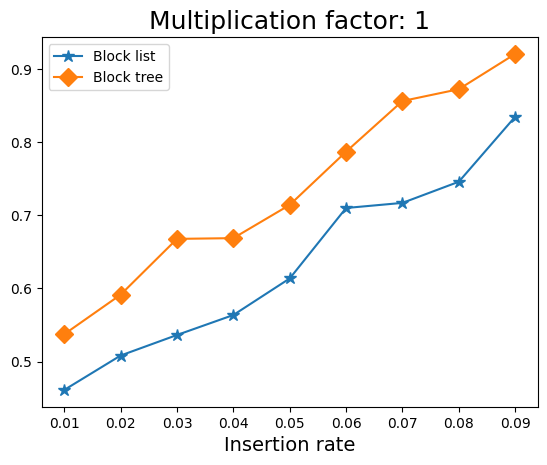

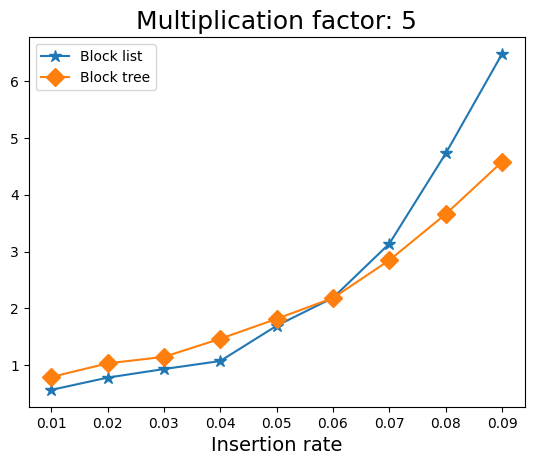

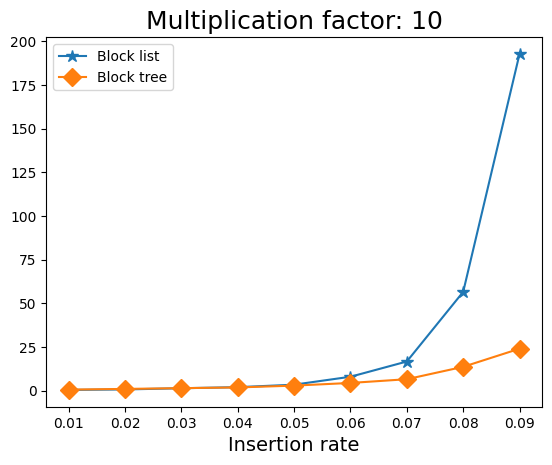

In [28]:
styles=['C0*-', 'C1D-']
for group in branches_df.groupby("branch_scale"):
    group[1][["blocklist_time", "blocktree_time", "insertion_rate"]].plot(x ="insertion_rate",
                                                                          style=styles, markersize=9)
    plt.title(f"Multiplication factor: {group[0]}", size=18)
    plt.xlabel("Insertion rate", size=14)
    plt.legend(labels=["Block list", "Block tree"])
    plt.savefig(f"assets/blocks_runtime_factor_{group[0]}.svg" ,bbox_inches="tight", dpi=300)
    plt.savefig(f"assets/blocks_runtime_factor_{group[0]}.png" ,bbox_inches="tight", dpi=300)


In [29]:
comparison_df.corr()

,branch_scale,blocklist_time,blocktree_time,true,factor,insertion_rate,deletion_rate
branch_scale,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blocklist_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blocktree_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,NaN,NaN,NaN,NaN,NaN,NaN,NaN
factor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
insertion_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deletion_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
comparison_df["dist"] = (comparison_df.true - comparison_df.factor)**2

In [11]:
comparison_df.loc[comparison_df["dist"].argmax()]

branch_scale        14.000000
blocklist_time      79.535264
blocktree_time      23.447037
true               174.000000
factor             140.000000
insertion_rate       0.090000
deletion_rate        0.010000
dist              1156.000000
Name: 0, dtype: float64

In [12]:
a = -2.0

zipf_sum = sum([x**a for x in range(1,51)])
avg = sum([x*(x**a/zipf_sum) for x in range(1,51)])
avg

2.768515608139384